In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import snap
from itertools import combinations
import numpy as np
from google.cloud import bigquery
import collections
from IPython.lib import backgroundjobs as bg
from tqdm import tqdm_notebook
import heapq

Construct bipartite graph for repository and developers

In [2]:
with open('./project_authors_2016_q1.pickle', 'rb') as picklefile:
    project_authors = pickle.load(picklefile)

In [3]:
authors = project_authors['author_id'].unique()
projects = project_authors['project_id'].unique()
bipartite = snap.TUNGraph.New()
for author in authors:
    bipartite.AddNode(author)
for project in projects:
    bipartite.AddNode(-project)
for _, row in project_authors.iterrows():
    bipartite.AddEdge(-row['project_id'], row['author_id'])
bipartite.GetNodes(), bipartite.GetEdges()

(598844, 1081257)

In [4]:
for _, row in project_authors.iterrows():
    bipartite.AddEdge(-row['project_id'], row['author_id'])

In [67]:
len([node for node in bipartite.Nodes() if node.GetId()>=0])

271848

In [30]:
ComponentDist = snap.TIntPrV()
snap.GetSccSzCnt(bipartite, ComponentDist)
for comp in ComponentDist:
    print "Size: %d - Number of Components: %d" % (comp.GetVal1(), comp.GetVal2())


Size: 2 - Number of Components: 75676
Size: 3 - Number of Components: 24697
Size: 4 - Number of Components: 10276
Size: 5 - Number of Components: 4920
Size: 6 - Number of Components: 2789
Size: 7 - Number of Components: 1598
Size: 8 - Number of Components: 1089
Size: 9 - Number of Components: 744
Size: 10 - Number of Components: 529
Size: 11 - Number of Components: 401
Size: 12 - Number of Components: 273
Size: 13 - Number of Components: 225
Size: 14 - Number of Components: 195
Size: 15 - Number of Components: 149
Size: 16 - Number of Components: 114
Size: 17 - Number of Components: 95
Size: 18 - Number of Components: 89
Size: 19 - Number of Components: 86
Size: 20 - Number of Components: 65
Size: 21 - Number of Components: 66
Size: 22 - Number of Components: 37
Size: 23 - Number of Components: 41
Size: 24 - Number of Components: 22
Size: 25 - Number of Components: 36
Size: 26 - Number of Components: 28
Size: 27 - Number of Components: 22
Size: 28 - Number of Components: 21
Size: 29 - 

In [5]:
bipartite_max_scc = snap.GetMxScc(bipartite)
bipartite_max_scc.GetNodes(), bipartite_max_scc.GetEdges()

(213039, 795843)

In [32]:
authors = [node for node in bipartite_max_scc.Nodes() if node.GetId()>=0]

In [34]:
len(authors), 213039-len(authors)

(89915, 123124)

In [45]:
author_deg = np.array([node.GetDeg() for node in bipartite_max_scc.Nodes() if node.GetId()>=0])

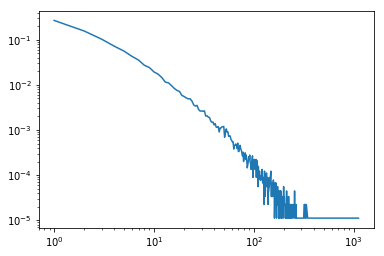

In [46]:
X = np.unique(author_deg)
Y = [float((author_deg == i).sum())/len(author_deg) for i in X]
plt.loglog(X, Y)

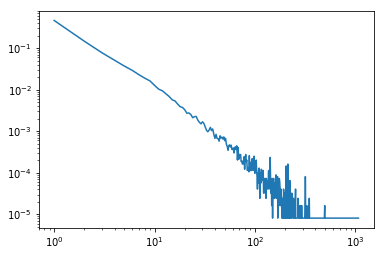

In [47]:
project_deg = np.array([node.GetDeg() for node in bipartite_max_scc.Nodes() if node.GetId()<0])
X = np.unique(project_deg)
Y = [float((project_deg == i).sum())/len(project_deg) for i in X]
plt.loglog(X, Y)

The number of edge bridges in the max connected component
An edge is a bridge if, when removed, increases the number of connected components.

In [36]:
EdgeV = snap.TIntPrV()
snap.GetEdgeBridges(bipartite_max_scc, EdgeV)
len(EdgeV)

97168

Approximate diameter of the max connected component

In [49]:
diam = snap.GetBfsFullDiam(bipartite_max_scc, 100, False)
print diam

29


In [6]:
jobs = bg.BackgroundJobManager()
PRankH = snap.TIntFltH()

In [52]:
jobs.new(lambda:snap.GetPageRank(bipartite_max_scc, PRankH))

Starting job # 0 in a separate thread.


<BackgroundJob #0: <function <lambda> at 0x120731398>>

In [73]:
jobs.completed

[]

In [56]:
for item in PRankH:
    if PRankH[item] > 4.69397622032e-06:
        print item, PRankH[item]

## Load Q2 data

In [7]:
with open('./project_authors_2016_q2.pickle', 'rb') as picklefile:
    project_authors_q2 = pickle.load(picklefile)
authors_q2 = project_authors_q2['author_id'].unique()
projects_q2 = project_authors_q2['project_id'].unique()

In [8]:
authors_q2 = set(authors_q2)
len(authors_q2)

218926

In [9]:
projects_q2 = set(projects_q2)
len(projects_q2)

245092

In [10]:
authors_q1 = set(node.GetId() for node in bipartite_max_scc.Nodes() if node.GetId()>=0)

In [76]:
len(authors_q1.difference(authors_q2))

39228

In [77]:
len(authors_q1.intersection(authors_q2))

50687

In [78]:
len(authors_q2.difference(authors_q1))

168239

In [11]:
jobs = bg.BackgroundJobManager()

In [12]:
projects_q1 = set(node.GetId() for node in bipartite_max_scc.Nodes() if node.GetId()<0)

In [13]:
bipartite_q2 = snap.TUNGraph.New()
for author in authors_q1:
    bipartite_q2.AddNode(author)
for project in projects_q1:
    bipartite_q2.AddNode(project)
for _, row in project_authors_q2.iterrows():
    if -row['project_id'] in projects_q1 and row['author_id'] in authors_q1:
        bipartite_q2.AddEdge(-row['project_id'], row['author_id'])
bipartite_q2.GetNodes(), bipartite_q2.GetEdges()

(213039, 423776)

In [14]:
q1_edges = set((edge.GetSrcNId(), edge.GetDstNId()) for edge in bipartite_max_scc.Edges())

In [15]:
q2_edges = set((edge.GetSrcNId(), edge.GetDstNId()) for edge in bipartite_q2.Edges())

In [16]:
len(q1_edges.intersection(q2_edges))

248252

In [86]:
len(q1_edges.difference(q2_edges))

547591

In [87]:
len(q2_edges.difference(q1_edges))

175524

We can see that in Q2 there're 175524 new edges among the 213039 nodes (89915 developer and 123124 repos) that we selected in Q1.
Now let's see how is the accuracy if we are to predict 175524 new edges using PA.

In [17]:
project_commits = collections.defaultdict(lambda : 0)
author_commits = collections.defaultdict(lambda : 0)
commits = collections.defaultdict(lambda : 0)
for _, row in project_authors.iterrows():
    project_commits[-row['project_id']] += row['commit_times']
    author_commits[row['author_id']] += row['commit_times']
    commits[(-row['project_id'], row['author_id'])] = row['commit_times']

In [22]:
degrees = {node.GetId(): node.GetDeg() for node in bipartite_max_scc.Nodes()}

In [18]:
def prefer_attach(authors, projects, author_weights, project_weights, K, queue):
    for project in tqdm_notebook(projects, desc='projects', mininterval=1): 
        for author in authors:
            weight = author_weights[author] * project_weights[project]
            if len(queue) < K:
                heapq.heappush(queue, (weight, (project, author)))
            else:
                heapq.heappushpop(queue, (weight, (project, author)))

In [19]:
K = 175524
pqueue = []
jobs.new(lambda:prefer_attach(authors_q1, projects_q1, author_commits, project_commits, K, pqueue))

Starting job # 0 in a separate thread.


<BackgroundJob #0: <function <lambda> at 0x12315ea28>>

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdwcm9qZWN0cycsIG1heD0xMjMxMjQsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


In [28]:
pqueue

[(972016, (-22015450, 978)),
 (972020, (-30669755, 18257)),
 (972019, (-31150321, 16646)),
 (972020, (-30669755, 3062954)),
 (972020, (-30669755, 30139)),
 (972019, (-30668858, 16646)),
 (972020, (-30669755, 10404)),
 (972026, (-47969631, 2027550)),
 (972048, (-490913, 3204108)),
 (972020, (-30669755, 160728)),
 (972026, (-47969631, 191454)),
 (972040, (-19081413, 103640)),
 (972020, (-30669755, 167770)),
 (972072, (-3931825, 8840375)),
 (972054, (-11793080, 138592)),
 (972054, (-11793080, 3508274)),
 (972048, (-490913, 2639685)),
 (972054, (-11793080, 4669589)),
 (972054, (-11793080, 127867)),
 (972020, (-30669755, 2652462)),
 (972054, (-11793080, 1041930)),
 (972072, (-3931825, 63148)),
 (972190, (-17295025, 9706192)),
 (972072, (-3931825, 6371130)),
 (972160, (-47782761, 120034)),
 (972020, (-30669755, 6903462)),
 (972048, (-490913, 8323955)),
 (972138, (-31194200, 35625)),
 (972160, (-26474057, 120034)),
 (972054, (-11793080, 162146)),
 (972138, (-31194200, 398368)),
 (972054, (-11

In [24]:
def prefer_attach_unweighted(authors, projects, weights, K, queue):
    for project in tqdm_notebook(projects, desc='projects', mininterval=1): 
        for author in authors:
            weight = weights[author] * weights[project]
            if len(queue) < K:
                heapq.heappush(queue, (weight, (project, author)))
            else:
                heapq.heappushpop(queue, (weight, (project, author)))

In [25]:
K = 175524
pqueue_unweighted = []
jobs.new(lambda:prefer_attach_unweighted(authors_q1, projects_q1, degrees, K, pqueue_unweighted))

Starting job # 2 in a separate thread.


<BackgroundJob #2: <function <lambda> at 0x12315e5f0>>

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdwcm9qZWN0cycsIG1heD0xMjMxMjQsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


In [29]:
pqueue_unweighted

[(3536, (-54547744, 98190)),
 (3536, (-54547744, 99701)),
 (3536, (-54547744, 121631)),
 (3536, (-54547744, 242310)),
 (3536, (-54547744, 124096)),
 (3536, (-54547744, 530542)),
 (3536, (-54547744, 743014)),
 (3536, (-54547744, 248412)),
 (3536, (-54547744, 1581422)),
 (3536, (-54547744, 173399)),
 (3536, (-54547744, 653962)),
 (3536, (-54547744, 884632)),
 (3536, (-54547744, 1540040)),
 (3536, (-54547744, 934742)),
 (3536, (-54547744, 1010855)),
 (3536, (-54547744, 712725)),
 (3536, (-54547744, 364156)),
 (3536, (-54547744, 1938346)),
 (3536, (-54547744, 2015534)),
 (3536, (-54547744, 259268)),
 (3536, (-54547744, 474712)),
 (3536, (-54547744, 1474962)),
 (3536, (-54547744, 3220914)),
 (3536, (-54547744, 2399856)),
 (3536, (-54547744, 4242141)),
 (3536, (-54547744, 2904515)),
 (3536, (-44038852, 1506598)),
 (3536, (-54547744, 967970)),
 (3536, (-54547744, 3720742)),
 (3536, (-54547744, 2010695)),
 (3536, (-54547744, 2451879)),
 (3536, (-54547744, 7471974)),
 (3536, (-54547744, 1903052